# Dear Jupyter Notebook Reader

In [1]:
# import all necessary packages 
# Standards 
import pandas as pd 
import numpy as np
import os 
import math

# Visulaizations
import seaborn as sns
import folium
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# my little helpers
from src import helpers
from src import Textprocessor 
from src import Distance_Calculator 


In [2]:
# read in data set 
train = helpers.read_df('data/train.csv', index_col='listing_id')
test = helpers.read_df('data/test.csv', index_col='listing_id')
reviews = helpers.read_df('data/reviews.csv', index_col='listing_id')

In [3]:
#  change data types because of memory reasons
train = helpers.change_data_types(train)
test = helpers.change_data_types(test)
reviews = helpers.change_data_types(reviews)

TypeError: 'int' object is not iterable

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55284 entries, 9Q1RD6H7IO to BKSRYBXCFL
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   name                         55270 non-null  category      
 1   summary                      52330 non-null  category      
 2   space                        38403 non-null  category      
 3   description                  53558 non-null  category      
 4   experiences_offered          55284 non-null  category      
 5   neighborhood_overview        35778 non-null  category      
 6   transit                      35477 non-null  category      
 7   house_rules                  31906 non-null  category      
 8   picture_url                  55284 non-null  category      
 9   host_id                      55284 non-null  int32         
 10  host_since                   55173 non-null  datetime64[ns]
 11  host_response_time           374

In [5]:
# Merge reviews on train using listing_id
train_review = train.merge(reviews, on='listing_id')

In [7]:
# lets split our data set in 3 different categories to make analyse simpler
host, airbnb, review_scores = helpers.split_df(train)

In [55]:
airbnb.amenities[0]


'{Wifi,"Paid parking off premises",Heating,Washer,"Smoke detector","Carbon monoxide detector","First aid kit",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50","Hot water","Bed linens","Extra pillows and blankets","Dishes and silverware","Luggage dropoff allowed","Host greets you","Handheld shower head"}'

In [30]:
airbnb.description[6]

'Luxurious, two double bedroom apartment situated on the highly sought after Walpole Court development next to Ealing Studios. This split level property has an amazing roof terrace and has been finished to the highest specification throughout. The property has easy access to Ealing Broadway and South Ealing tube stations and backs onto Historic Walpole Park. The unfurnished apartment also has a allocated parking space. Luxurious Development  Great Location  Split Level  Roof Terrace  Allocated Parking  Two Double Bedrooms Estate manager available during all working hours and on call out on evenings and early mornings. Ealing Broadway (0.4 mi) - Central Line South Ealing (0.6 mi) West Ealing (0.7 mi)'

In [60]:
host[host.host_has_profile_pic.isnull()]

,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified
listing_id,,,,,,,,


In [61]:
review_scores

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month
listing_id,,,,,,,,,
9Q1RD6H7IO,95.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.37
6XDPZPGLSR,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,2.97
SND9OPN6IY,84.0,9.0,9.0,10.0,10.0,9.0,8.0,strict_14_with_grace_period,1.73
SE3B7BXN9G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN
E0C82VK0VF,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.32
...,...,...,...,...,...,...,...,...,...
HSY40NEHOI,100.0,10.0,10.0,10.0,10.0,9.0,10.0,strict_14_with_grace_period,0.20
XZXB1NS63Y,100.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,0.08
Z2T8G6D82D,96.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,1.60


# Explorative Data Analysis

Text(0.5, 1.0, 'Neighbourhood Group')

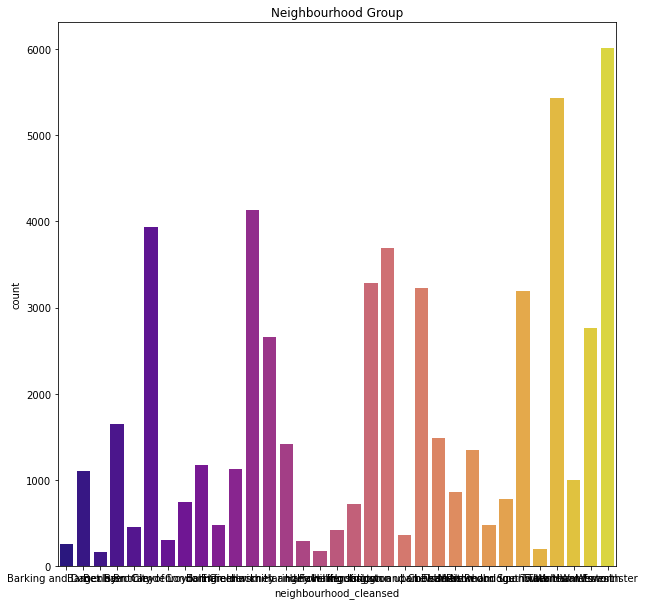

In [45]:
sns.countplot(train['neighbourhood_cleansed'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Neighbourhood Group')

In [26]:
# Create map
lonlat = list(zip(train.longitude, train.latitude))
mapit = folium.Map( location=[52.667989, -1.464582], zoom_start=6 )
for coord in lonlat:
    folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=8 ).add_to( mapit )

mapit.save( 'map.html')